In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp

import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
myhost = os.uname()[1]
if myhost == 'macmazzitelli.lnf.infn.it':
    mybasepath = '/Users/mazzitel/Dropbox/GR2/soft/data/'
    posix=False
else:
    mybasepath = '/workarea/cloud-storage/mazzitel/'
    posix=True
print("Host:", myhost)
print (sys.version, get_ipython())
if 'google.colab' in str(get_ipython()) and sys.version[0:1] in '2':
    mybasepath = './'
    posix=False
    print('Running on CoLab')

Welcome to JupyROOT 6.22/06
Host: a4d622cddfaa
3.6.8 (default, Nov 16 2020, 16:55:22) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)] <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f85076fe7b8>


In [2]:
def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
    
def histGaus(var, bins, ax, color='b', xrange=False, alpha=1, label=''):
    from sklearn.metrics import r2_score
    from scipy.stats import chisquare
    import scipy.stats as stats
    if xrange:
        ax.hist(var, bins=bins, label=label, color=color, range=(xrange[0], xrange[1]), alpha=alpha)
        y, bins_edge = np.histogram(var, bins=bins, range=(xrange[0], xrange[1]))
    else:
        ax.hist(var, bins=bins, label=label, color=color)
        y, bins_edge = np.histogram(var, bins=bins)
    p0=[y.max(),bins_edge[y.argmax()], var.std()]
    x = np.linspace(bins_edge[0], bins_edge[-1], bins)
    popt, pcov = curve_fit(Gauss3, x, y, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    r2=r2_score(y, Gauss3(x, *popt))
    x = np.linspace(bins_edge[0], bins_edge[-1], 100)
    sstat='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
    \nc = {4:.2f} +/- {5:.2f}\n$R^2$ = {6:.4f}'.format(popt[0], perr[0], popt[1], perr[1], 
                                                popt[2], perr[2], r2)
    ax.plot(x,Gauss3(x, *popt), color+'--', label=sstat)
    return ax
def ExpG(x, p0, p1, a0, x0, s0): # power of ten
    import numpy as np
    return p0*np.exp(p1*x) + a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def Exp(x, p0, p1): # power of ten
    import numpy as np
    return p0*np.exp(p1*x)

def G3(x, a0, x0, s0): # power of ten
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def myExpG(data,ax, xmin, xmax, bins, E0, E1, a0, x0, s0):
    y = data[(data > xmin) & (data < xmax)]
    binsf = int(bins*((xmax-xmin)/(y.max()-y.min())))
    x=np.linspace(xmin , xmax, binsf)
    yh, _ = np.histogram(y, bins=binsf, range=(xmin,xmax))
    popt, pcov = curve_fit(ExpG, x, yh, 
                            p0=(E0, E1, a0, x0, s0))    
    #print ("Params: ", popt) 
    perr = np.sqrt(np.diag(pcov))
    #print ("err: ", perr)
    # plt.title(r'E0*$e^{(E1*x)}$ + a0*$e^{-\frac{(x - x0)^2}{2*s0^2}}$', fontsize=30)
    ax.plot(x, ExpG(x, *popt), 'r--', linewidth=2,
    label='E0 = %.2e +/- %.2e\nE1 = %.2e +/- %.2e\na0 = %.2e +/- %.2e\nx0 = %.2e +/- %.2e\ns0 = %.2e +/- %.2e' % 
                          (popt[0], perr[0],  popt[1],perr[1],
                           popt[2],perr[2], popt[3], perr[3], popt[4], perr[4]))
    ax.plot(x, G3(x, popt[2], popt[3], popt[4]), 'b-', label='signal')
    ax.plot(x, Exp(x, popt[0], popt[1]), 'y-', label='background')
    return ax, popt




In [3]:
#
# carica i dati dal file
#
# bandella
file_out=mybasepath+"out/dbscan_run4184_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz"
file_out=mybasepath+"out/dbscan_run4184_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz"
# KFC
file_out=mybasepath+"out/dbscan_run4039_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz"
file_out=mybasepath+"out/dbscan_run4046_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz"
df = pd.read_pickle(file_out, compression='gzip')

# range
# charge distribution
# charge asimettriy

df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
df['x0c'] = (df['x0end'] + df['x0start'])/2.
df['y0c'] = (df['y0end'] + df['y0start'])/2.
df = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]

In [4]:
df

,iTr,cluster_lable,pixels,photons,ph_pixels,x0start,y0start,x0end,y0end,width,height,pearson,length,x0c,y0c
0,0.0,0.0,125.0,786.920,6.295360,1242.0,139.0,1245.0,148.0,13.814602,15.634052,0.045364,9.486833,1243.5,143.5
1,0.0,1.0,239.0,1464.460,6.127448,1226.0,143.0,1227.0,161.0,19.687132,23.033296,0.235434,18.027756,1226.5,152.0
2,0.0,2.0,123.0,809.165,6.578577,1238.0,159.0,1236.0,169.0,11.576821,18.121300,-0.290242,10.198039,1237.0,164.0
3,0.0,3.0,754.0,4390.350,5.822745,1229.0,169.0,1217.0,193.0,33.047244,40.967978,-0.553167,26.832816,1223.0,181.0
4,0.0,4.0,419.0,2751.575,6.567005,1195.0,168.0,1201.0,192.0,24.108365,32.901933,0.108914,24.738634,1198.0,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21899,199.0,146.0,478.0,2894.335,6.055094,1140.0,1817.0,1141.0,1841.0,28.631230,31.076425,0.029310,24.020824,1140.5,1829.0
21900,199.0,147.0,161.0,645.525,4.009472,761.0,1825.0,768.0,1834.0,19.484273,14.527728,0.107860,11.401754,764.5,1829.5
21901,199.0,148.0,210.0,956.545,4.554976,1010.0,1868.0,1012.0,1882.0,19.067728,19.318673,0.281055,14.142136,1011.0,1875.0
21902,199.0,149.0,242.0,1230.410,5.084339,778.0,1886.0,781.0,1902.0,17.039485,25.412597,-0.074257,16.278821,779.5,1894.0


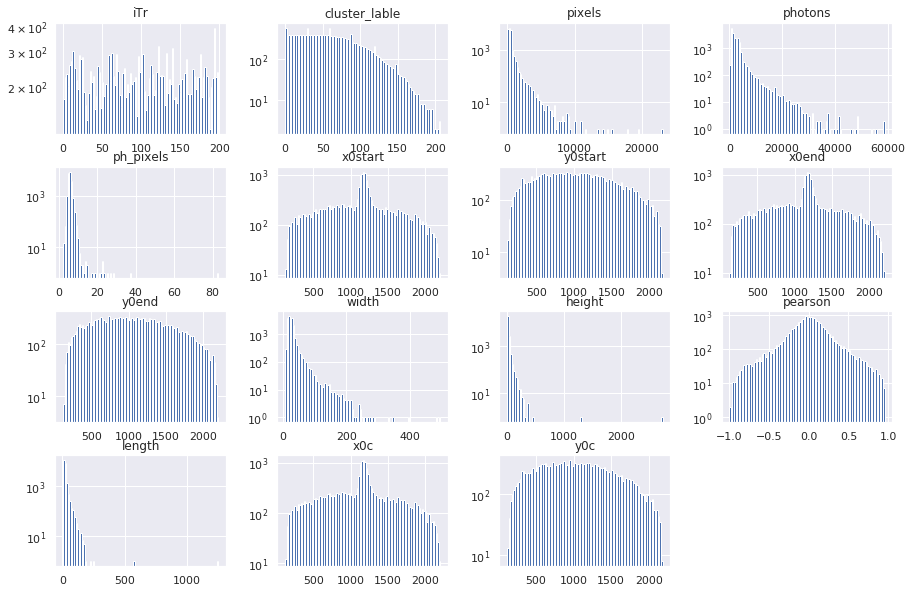

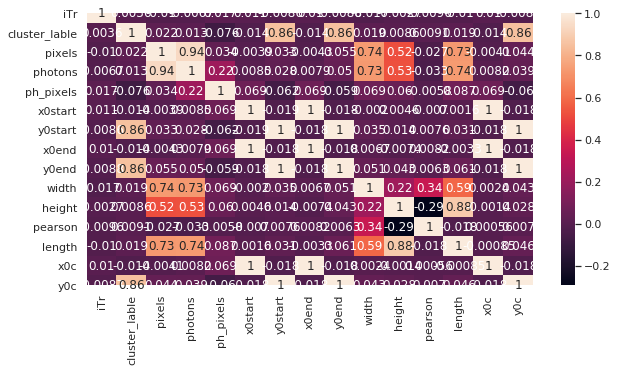

In [5]:
import seaborn as sns
sns.set()
#
# Visulizza tutte le Varibili
#
df.hist(bins=100, figsize=(15,10), log=True)
plt.show()

plt.figure(figsize = (10,5))
sns.heatmap(df.corr(), annot=True)
plt.show()

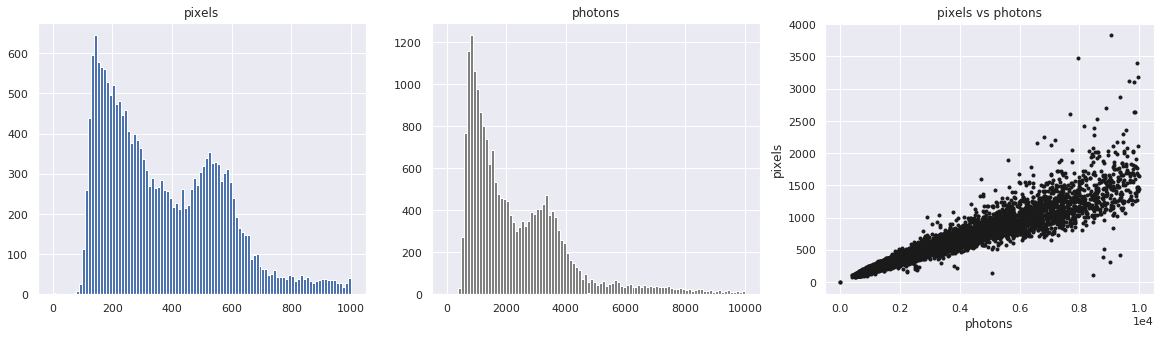

In [6]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].set_title('pixels')
ax[0].hist(df.pixels, 100, range=(0,1000))
ax[1].set_title('photons')
phmax=10000
ax[1].hist(df.photons, 100, range=(0,phmax), color="gray")
ax[1].hist(df.photons[df.pearson>0.8], 100, range=(0,phmax), color="green")
ax[2].set_title('pixels vs photons')
ax[2].plot(df.photons[df.photons<phmax].values, df.pixels[df.photons<phmax].values, 'k.')
ax[2].set_xlabel('photons')
ax[2].set_ylabel('pixels')
ax[2].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
plt.show()

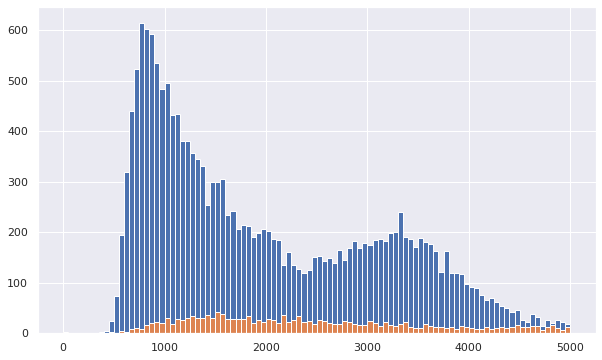

In [7]:
#
# Visualizziamo i fotoni
#
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df.photons[abs(df.pearson)<0.4], 100, range=(0,5000))
ax.hist(df.photons[abs(df.pearson)>0.4], 100, range=(0,5000))
#ax.set_yscale('log')
plt.show()

/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


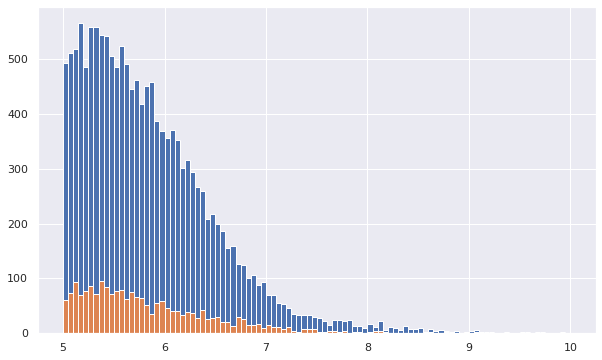

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df.ph_pixels[abs(df.pearson)<0.4], 100, range=(5,10))
ax.hist(df.ph_pixels[abs(df.pearson)>0.4], 100, range=(5,10))
#ax.set_yscale('log')
plt.show()

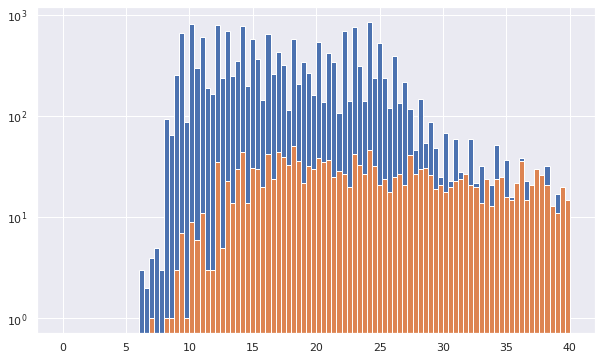

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df.length[abs(df.pearson)<0.4], 100, range=(0,40))
ax.hist(df.length[abs(df.pearson)>0.4], 100, range=(0,40))
ax.set_yscale('log')
plt.show()

Fidical Circle: 75.00 [mm]


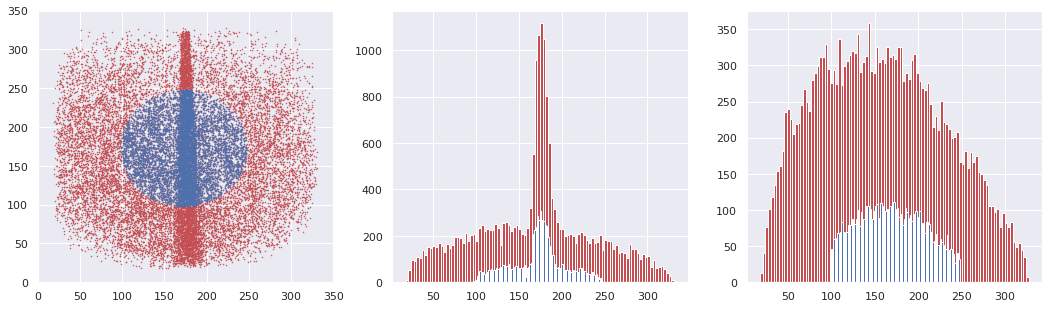

In [10]:
pd.set_option('mode.chained_assignment', None)

# Normalization

LEMON = False

if LEMON:
    # LEMON
    pixelscale  = 0.125 
    x_resolution = y_resolution = 2048
    df['length']   =df['length']*pixelscale
    df['x0c']      =df['x0c']*pixelscale
    df['y0c']      =df['y0c']*pixelscale

    # fiducializzation

    DX = 0 
    DY = 0
    a = 100. # mm 
    b = 120. # mm

    a0 = a*0.5
    b0 = b*0.5
    #################################################


    print ("Fidical Ellips: %.2f, %.2f [mm]" % (a,b))

    d0 = x_resolution*pixelscale/2

    fig, ax = plt.subplots(1,3, figsize=(18, 5))

    y = df['y0c'].values
    x = df['x0c'].values
    x1 = x[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
    y1 = y[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
    ax[0].plot(x, y, 'r.', markersize=1)
    ax[0].plot(x1, y1, 'b.', markersize=1)
    ax[0].set_xlim(0,256)
    ax[0].set_ylim(0,256)
    ax[1].hist(x, color='r',bins=100)
    ax[1].hist(x1, color='b',bins=100)
    ax[2].hist(y, color='r',bins=100)
    ax[2].hist(y1, color='b',bins=100)
    plt.show()

    df = df[((df['x0c']-d0)**2/a0**2 + (df['y0c']-d0)**2/b0**2 )< 1]
else:
    
    # LIME
    DX = 0 
    DY = 0

    pixelscale  = 0.150 
    x_resolution = y_resolution = 2304


    df['length']   =df['length']*pixelscale
    df['x0c']      =df['x0c']*pixelscale
    df['y0c']      =df['y0c']*pixelscale
    
    a0 = 150*.5
    print ("Fidical Circle: %.2f [mm]" % (a0))
    d0 = x_resolution*pixelscale/2

    fig, ax = plt.subplots(1,3, figsize=(18, 5))

    y = df['y0c'].values
    x = df['x0c'].values
    x1 = x[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/a0**2 )< 1]
    y1 = y[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/a0**2 )< 1]
    ax[0].plot(x, y, 'r.', markersize=1)
    ax[0].plot(x1, y1, 'b.', markersize=1)
    ax[0].set_xlim(0,350)
    ax[0].set_ylim(0,350)
    ax[1].hist(x, color='r',bins=100)
    ax[1].hist(x1, color='b',bins=100)
    ax[2].hist(y, color='r',bins=100)
    ax[2].hist(y1, color='b',bins=100)
    plt.show()

    df = df[((df['x0c']-d0)**2/a0**2 + (df['y0c']-d0)**2/a0**2 )< 1]

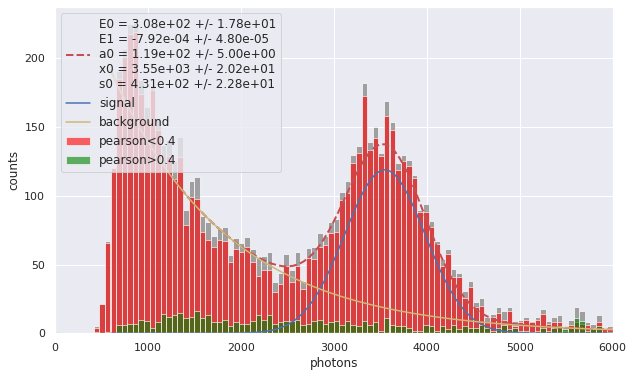

In [11]:
bins = 100

fig, ax = plt.subplots(figsize=(10,6))
hmax = 6000.
myExpG(df['photons'], ax, xmin=600., xmax=hmax, bins=100, E0=200., E1=-0.001, a0=900., x0=3000., s0=300.)
ax.hist(df['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
ax.hist(df.photons[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
ax.hist(df.photons[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
ax.set_xlim(0,hmax)
ax.set_xlabel('photons')
ax.set_ylabel('counts')
#ax.set_yscale("log")
plt.legend(loc=2, prop={'size':'medium'})
plt.minorticks_on()
plt.show()

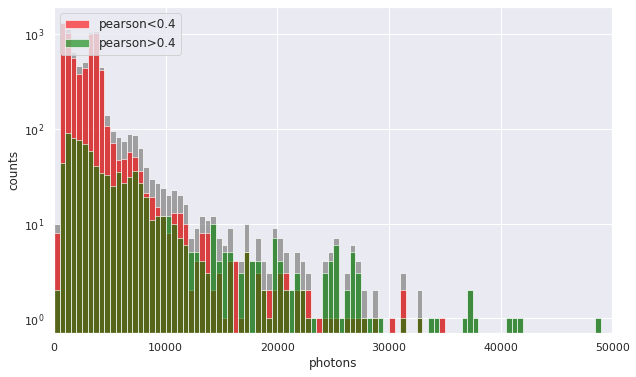

In [12]:
bins = 100

fig, ax = plt.subplots(figsize=(10,6))
hmax = 50000.
#myExpG(dfc['photons'], ax, xmin=600., xmax=hmax, bins=100, E0=200., E1=-0.001, a0=900., x0=3000., s0=300.)
ax.hist(df['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
ax.hist(df.photons[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
ax.hist(df.photons[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
ax.set_xlim(0,hmax)
ax.set_xlabel('photons')
ax.set_ylabel('counts')
ax.set_yscale("log")
plt.legend(loc=2, prop={'size':'medium'})
plt.minorticks_on()
plt.show()

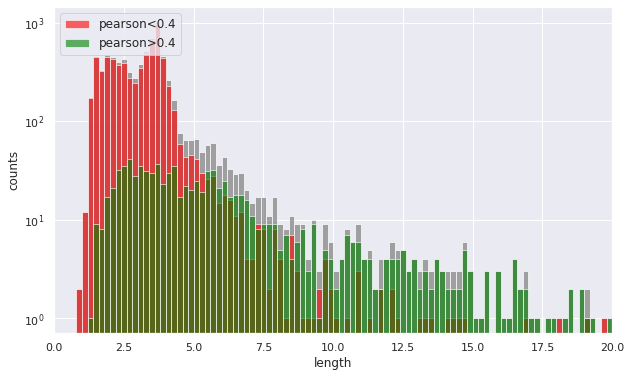

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
hmax=20
ax.hist(df.length, bins=100, range=(0,hmax), color='gray', alpha=0.7)
ax.hist(df.length[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
ax.hist(df.length[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
ax.set_xlim(0,hmax)
ax.set_xlabel('length')
ax.set_ylabel('counts')
ax.set_yscale("log")
plt.legend(loc=2, prop={'size':'medium'})
plt.minorticks_on()
plt.show()

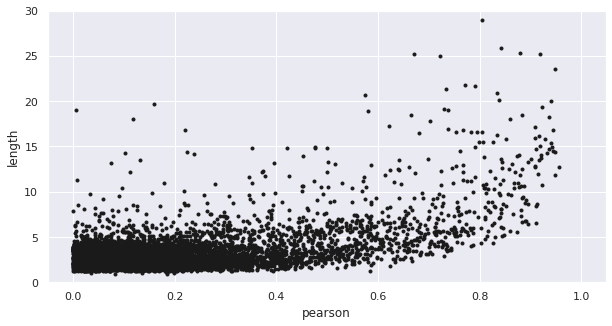

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(abs(df.pearson.values), df.length.values, 'k.')
ax.set_ylabel('length')
ax.set_xlabel('pearson')

ax.set_ylim(0,30)
plt.show()

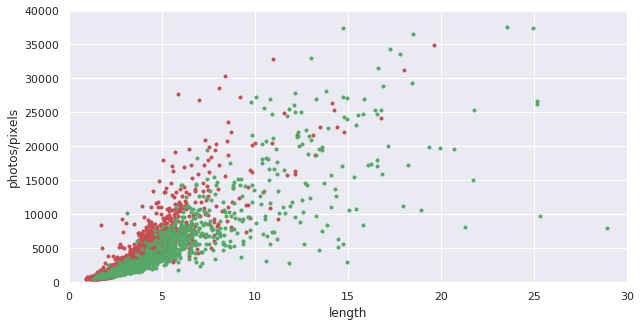

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
#ax.plot(df.length.values, df.ph_pixels.values, 'k.')
ax.plot(df.length.values[abs(df.pearson.values)<0.4], df.photons.values[abs(df.pearson.values)<0.4], 'r.')
ax.plot(df.length.values[abs(df.pearson.values)>0.4], df.photons.values[abs(df.pearson.values)>0.4], 'g.')
ax.set_ylabel('photos/pixels')
ax.set_xlabel('length')
ax.set_xlim(0,30)
ax.set_ylim(0,40000)
plt.show()

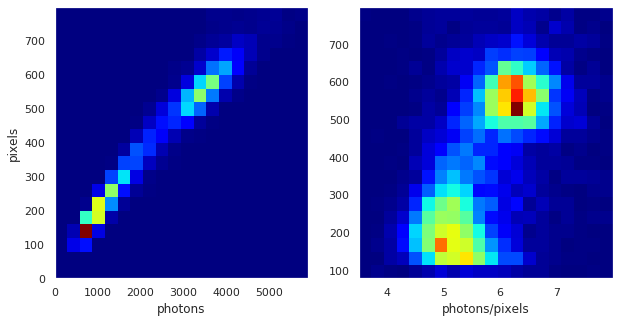

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
mpixe=800
mph=6000
mpphp_p = 8
ax[0].hist2d(df.photons.values[((df.pixels<mpixe)&(df.photons<mph))], 
           df.pixels.values[((df.pixels<mpixe)&(df.photons<mph))], 
           bins=(20,20), cmap=plt.cm.jet)
ax[0].set_xlabel("photons")
ax[0].set_ylabel("pixels")
ax[1].hist2d(df.ph_pixels.values[((df.pixels<mpixe)&(df.ph_pixels<mpphp_p))], 
           df.pixels.values[((df.pixels<mpixe)&(df.ph_pixels<mpphp_p))], 
           bins=(20,20), cmap=plt.cm.jet)
ax[1].set_xlabel("photons/pixels")
plt.show()

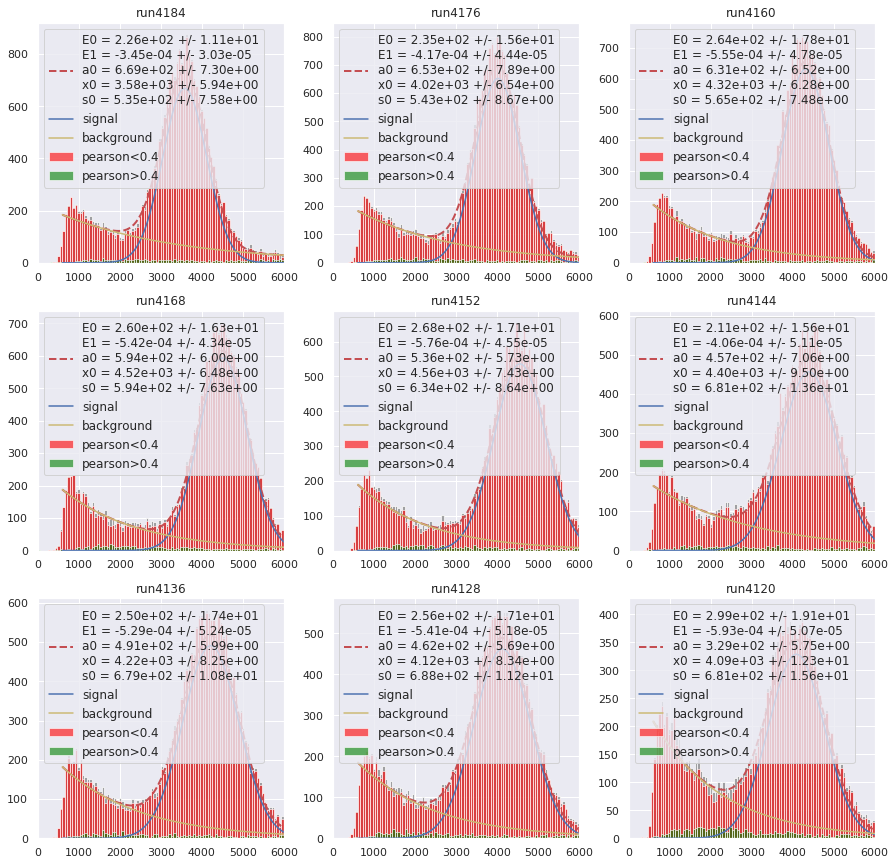

In [21]:
# Bandella
file_out=["dbscan_run4184_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4176_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4168_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4160_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4152_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4144_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4136_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_197_ped_4183.plk.gz",
         "dbscan_run4128_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4120_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz"]

d = {'run': [4184, 4176, 4160, 4168, 4152, 4144, 4136, 4128, 4120], 'd': [6.5, 11, 16, 21, 26, 31, 36, 41, 46]}

# kfc
#file_out=["dbscan_run4039_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
#         "dbscan_run4040_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
#         "dbscan_run4041_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
#         "dbscan_run4042_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
#         "dbscan_run4043_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
#         "dbscan_run4044_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
#         "dbscan_run4045_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
#         "dbscan_run4046_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
#         "dbscan_run4047_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz"]
#d = {'run': [4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047], 'd': [6.5, 11, 16, 21, 26, 31, 36, 41, 46]}

info = pd.DataFrame(data=d)

m = []
s = []
pixelscale  = 0.150 
x_resolution = y_resolution = 2304
d0 = x_resolution*pixelscale/2

# agistare il numero di file alla dimesione dei run analizzati
fig, ax = plt.subplots(3,3, figsize=(15,15))
xi = 0
yi = 0

for i, file in enumerate(file_out):
    df = pd.read_pickle(mybasepath+"out/"+file, compression='gzip')

    df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
    df['x0c'] = (df['x0end'] + df['x0start'])/2.
    df['y0c'] = (df['y0end'] + df['y0start'])/2.
    df = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]
    df['length']   =df['length']*pixelscale
    df['x0c']      =df['x0c']*pixelscale
    df['y0c']      =df['y0c']*pixelscale
    # print ("Fidical Circle: %.2f, %.2f [mm]" % (a,b))
    a0 = 150*.5
    df = df[((df['x0c']-d0)**2/a0**2 + (df['y0c']-d0)**2/a0**2 )< 1]
    bins = 100

    #fig, ax = plt.subplots(figsize=(10,6))
    ax[xi,yi].set_title('run'+str(info.iloc[i,0]))
#     if i < 2:
#         hmax = 6000.
#         E0=200.
#         E1=-0.001 
#         a0=100. 
#         x0=3500.
#         s0=300.
#     elif 2 < i < 5
#     else:
#         hmax = 6000.
#         E0=200.
#         E1=-0.001
#         a0=200.
#         x0=3000.
#         s0=300.

    hmax = 6000.
    E0=200.
    E1=-0.001
    a0=200.
    x0=4000.
    s0=300.

        
    _, popt= myExpG(df['photons'], ax[xi,yi], xmin=600., xmax=hmax, bins=100, E0=E0, E1=E1, a0=a0, x0=x0, s0=s0)
    m.append(popt[3])
    s.append(popt[4])
    ax[xi,yi].hist(df['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
    ax[xi,yi].hist(df.photons[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
    ax[xi,yi].hist(df.photons[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
    ax[xi,yi].set_xlim(0,hmax)
    #ax.set_yscale("log")
    ax[xi,yi].legend(loc=2, prop={'size':'medium'})
    #plt.minorticks_on()
    yi+=1
    if yi == 3:
        xi+=1
        yi = 0
plt.show()
info['m'] = m
info['s']= s
ban = info

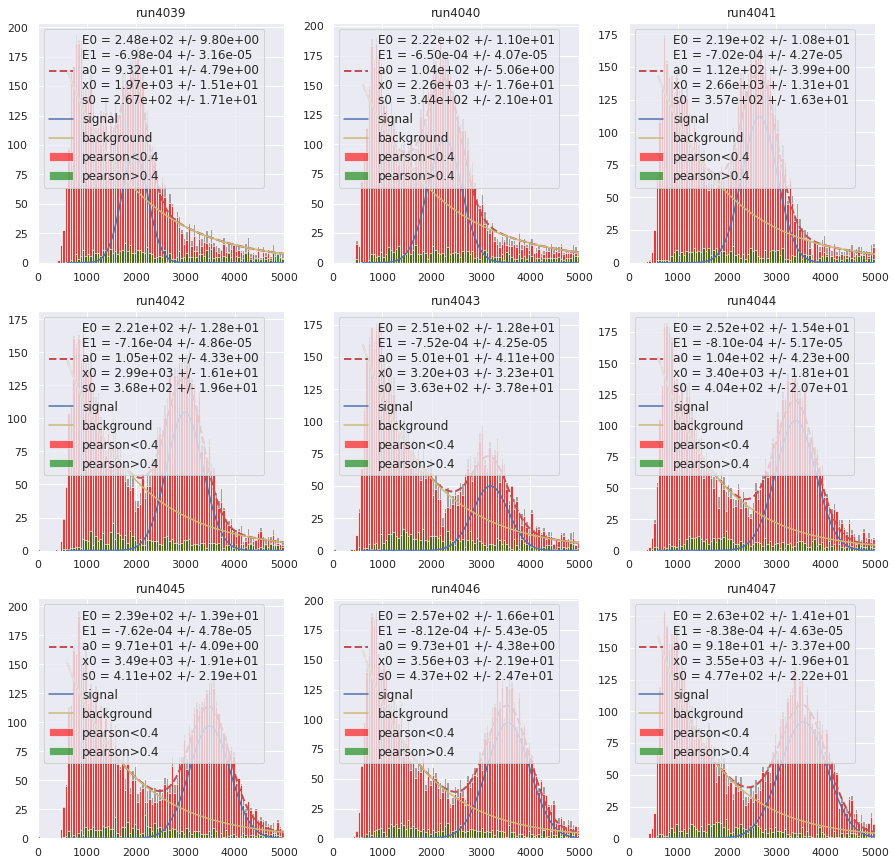

In [22]:
# kfc
file_out=["dbscan_run4039_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4040_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4041_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4042_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4043_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4044_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4045_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4046_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4047_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz"]
d = {'run': [4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047], 'd': [6.5, 11, 16, 21, 26, 31, 36, 41, 46]}

info = pd.DataFrame(data=d)

m = []
s = []
pixelscale  = 0.150 
x_resolution = y_resolution = 2304
d0 = x_resolution*pixelscale/2

# agistare il numero di file alla dimesione dei run analizzati
fig, ax = plt.subplots(3,3, figsize=(15,15))
xi = 0
yi = 0

for i, file in enumerate(file_out):
    df = pd.read_pickle(mybasepath+"out/"+file, compression='gzip')

    df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
    df['x0c'] = (df['x0end'] + df['x0start'])/2.
    df['y0c'] = (df['y0end'] + df['y0start'])/2.
    df = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]
    df['length']   =df['length']*pixelscale
    df['x0c']      =df['x0c']*pixelscale
    df['y0c']      =df['y0c']*pixelscale
    # print ("Fidical Circle: %.2f, %.2f [mm]" % (a,b))
    a0 = 150*.5
    df = df[((df['x0c']-d0)**2/a0**2 + (df['y0c']-d0)**2/a0**2 )< 1]
    bins = 100

    #fig, ax = plt.subplots(figsize=(10,6))
    ax[xi,yi].set_title('run'+str(info.iloc[i,0]))
    if i < 2:
        hmax = 3000.
        E0=200.
        E1=-0.001 
        a0=100. 
        x0=2000.
        s0=300.
    else:
        hmax = 4000.
        E0=200.
        E1=-0.001
        a0=200.
        x0=3000.
        s0=300.
    hmax = 5000.
        
    _, popt= myExpG(df['photons'], ax[xi,yi], xmin=600., xmax=hmax, bins=100, E0=E0, E1=E1, a0=a0, x0=x0, s0=s0)
    m.append(popt[3])
    s.append(popt[4])
    ax[xi,yi].hist(df['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
    ax[xi,yi].hist(df.photons[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
    ax[xi,yi].hist(df.photons[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
    ax[xi,yi].set_xlim(0,hmax)
    #ax.set_yscale("log")
    ax[xi,yi].legend(loc=2, prop={'size':'medium'})
    #plt.minorticks_on()
    yi+=1
    if yi == 3:
        xi+=1
        yi = 0
plt.show()
info['m'] = m
info['s']= s
kfc = info

In [23]:
def par_fits(info,  col='r-'):
    fig, ax = plt.subplots(1,3, figsize=(20,4))
    ax[0].set_ylabel("photons")
    ax[0].set_xlabel("ditance [cm]")
    ax[0].plot(info.d.values, info.m.values, col)
    ax[1].set_ylabel("sigma")
    ax[1].set_xlabel("ditance [cm]")
    ax[1].plot(info.d.values, info.s.values, col)
    ax[2].set_ylabel("resolution")
    ax[2].set_xlabel("ditance [cm]")
    ax[0].set_ylim(1000,5000)
    ax[1].set_ylim(200,800)
    ax[2].set_ylim(0.10,0.20)

    ax[2].plot(info.d.values, info.s.values/info.m.values, col)
    #ax[0].set_ylim(2000,4000)
    #ax[1].set_ylim(300,700)
    plt.show()

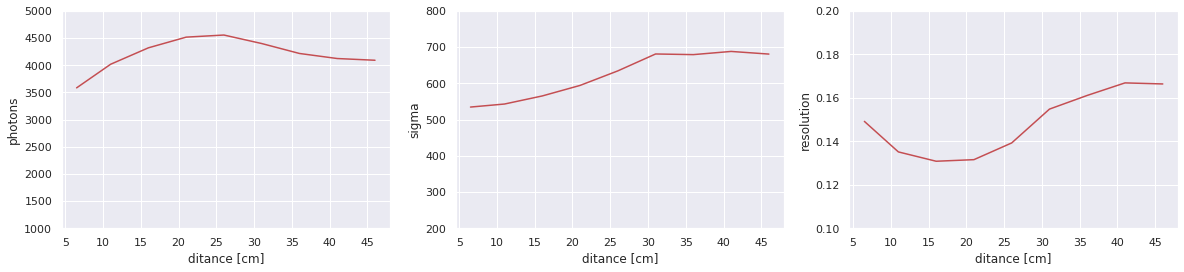

In [24]:
par_fits(ban)

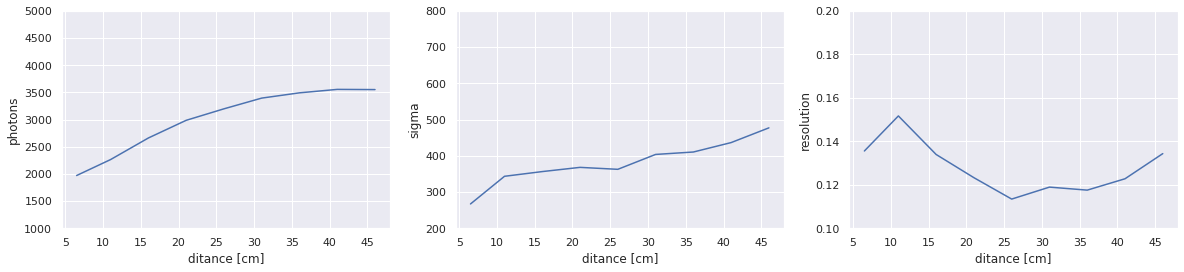

In [25]:
par_fits(kfc, col='b-')

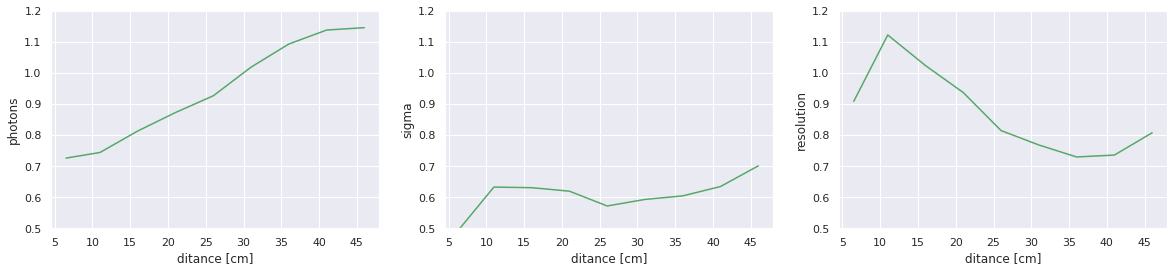

In [31]:
fig, ax = plt.subplots(1,3, figsize=(20,4))
ax[0].set_ylabel("photons")
ax[0].set_xlabel("ditance [cm]")
ax[0].plot(info.d.values, kfc.m.values*1.32/ban.m.values, 'g-')
ax[1].set_ylabel("sigma")
ax[1].set_xlabel("ditance [cm]")
ax[1].plot(info.d.values, kfc.s.values/ban.s.values, 'g-')
ax[2].set_ylabel("resolution")
ax[2].set_xlabel("ditance [cm]")
ax[0].set_ylim(0.5,1.2)
ax[1].set_ylim(0.5,1.2)
ax[2].set_ylim(0.5,1.2)

ax[2].plot(info.d.values, (kfc.s.values/kfc.m.values)/(ban.s.values/ban.m.values), 'g-')
#ax[0].set_ylim(2000,4000)
#ax[1].set_ylim(300,700)
plt.show()

In [91]:
!ls

AnalisiCluster.ipynb  Fe.ipynb	 __pycache__   cygnus_lib.py  mylib.py	  test
Fe-Copy1.ipynb	      README.md  cosmic.ipynb  display.ipynb  pippo.root


In [94]:
! echo $file_out

[dbscan_run4184_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz, dbscan_run4176_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz, dbscan_run4168_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz, dbscan_run4160_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz, dbscan_run4152_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz, dbscan_run4144_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz, dbscan_run4136_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_197_ped_4183.plk.gz, dbscan_run4128_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz, dbscan_run4120_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz]


In [101]:
file_out=["dbscan_run4184_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4176_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4168_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4160_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4152_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4144_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4136_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_197_ped_4183.plk.gz",
         "dbscan_run4128_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4120_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz"]
file_out=["dbscan_run4039_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4040_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4041_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4042_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4043_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4044_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4045_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4046_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
        "dbscan_run4047_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz"]


In [102]:
for i, file in enumerate(file_out):
    da = mybasepath+"out/"+file
    a = mybasepath+"bck/"+file
    print("cp "+da+" a "+a)
    ! cp $da $a 

cp /workarea/cloud-storage/mazzitel/out/dbscan_run4039_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz a /workarea/cloud-storage/mazzitel/bck/dbscan_run4039_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz
cp /workarea/cloud-storage/mazzitel/out/dbscan_run4040_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz a /workarea/cloud-storage/mazzitel/bck/dbscan_run4040_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz
cp /workarea/cloud-storage/mazzitel/out/dbscan_run4041_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz a /workarea/cloud-storage/mazzitel/bck/dbscan_run4041_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz
cp /workarea/cloud-storage/mazzitel/out/dbscan_run4042_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz a /workarea/cloud-storage/mazzitel/bck/dbscan_run4042_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz
cp /workarea/cloud-storage/mazzitel/out/dbscan_run4043_cmin_